In [15]:
import h5py
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import torch
from torchvision import transforms
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torchview import draw_graph
from torch import nn

In [17]:
class Dataset:
    def __init__(self, file):
        self.model = CLIPModel.from_pretrained("vinid/plip").vision_model
        with h5py.File(file) as dataset:
            pass
        
def init_model(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight)
    if module.bias is not None:
        nn.init.zeros_(module.bias)
        
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision_model = CLIPModel.from_pretrained("vinid/plip").vision_model
        self.stack = nn.Sequential(self.vision_model, 
                              nn.Linear(768, 384), nn.ReLU,
                              nn.Linear(384, 192), nn.ReLU,
                              nn.Linear(192, 48), nn.ReLU,
                              nn.Linear(48,2), nn.Softmax)
        self.apply(init_model)
        
    def forward(self, x):
        return self.stack(x)

In [ ]:
model = Model()
model()

In [2]:
TRAIN_IMAGES_PATH = 'train.h5'
VAL_IMAGES_PATH = 'val.h5'
TEST_IMAGES_PATH = 'test.h5'
SEED = 0
FILES = ['train.h5', 'val.h5', 'test.h5']

In [3]:
torch.random.manual_seed(SEED)
random.seed(SEED)

In [14]:
h5_file = h5py.File('train.h5', 'r') 
keys = h5_file.keys()
print("labels", h5_file['0']['label'][()])

labels 0


In [5]:
'''
    # Access the 'idx' group (assuming it's a group)
    list = []
    for item in keys:
        idx_group = h5_file[item]
        list.append(idx_group['label'][()])
        Counter(list)
'''

"\n    # Access the 'idx' group (assuming it's a group)\n    list = []\n    for item in keys:\n        idx_group = h5_file[item]\n        list.append(idx_group['label'][()])\n        Counter(list)\n"

In [6]:
model = CLIPModel.from_pretrained("vinid/plip")
processor = CLIPProcessor.from_pretrained("vinid/plip")

In [16]:
vision_model = model.vision_model
list(vision_model.modules())[-1]

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

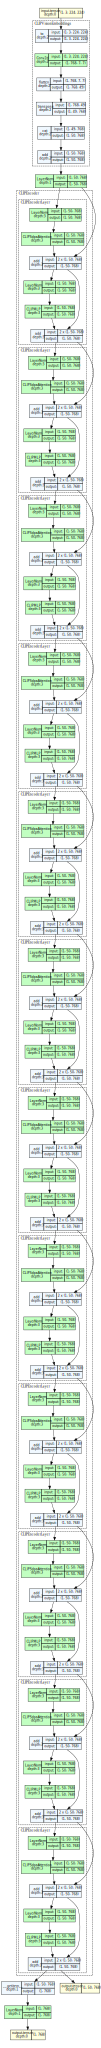

In [8]:
model_graph = draw_graph(vision_model, input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

tensor([[0.7082, 0.2918]], grad_fn=<SoftmaxBackward0>)


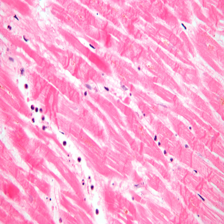

In [24]:
image = Image.open("Photo2.jpg")

inputs = processor(text=["a photo of alveola", "a photo of column cancer", "Micrograph showing contraction band necrosis, a histopathologic finding of myocardial infarction (heart attack)"],
                   images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  
print(probs)
image.resize((224, 224))